<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_VAR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [12]:
# 該当リポジトリを変数に格納
c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" ) -> repo
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/population_jp_year.csv" )) -> popURL

# ライブラリの読み込み
library( readr )
library( fable )

# ネット上のファイル読み込み
popURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> pop_tsibble

# 手順２　データの可視化

まず、データをプロットしてみます。

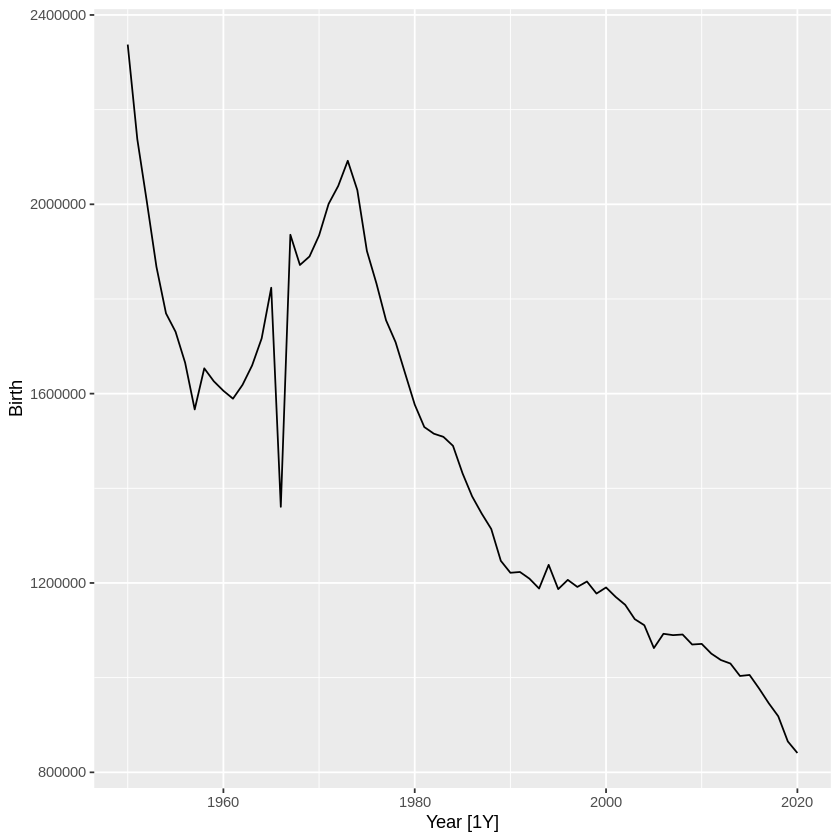

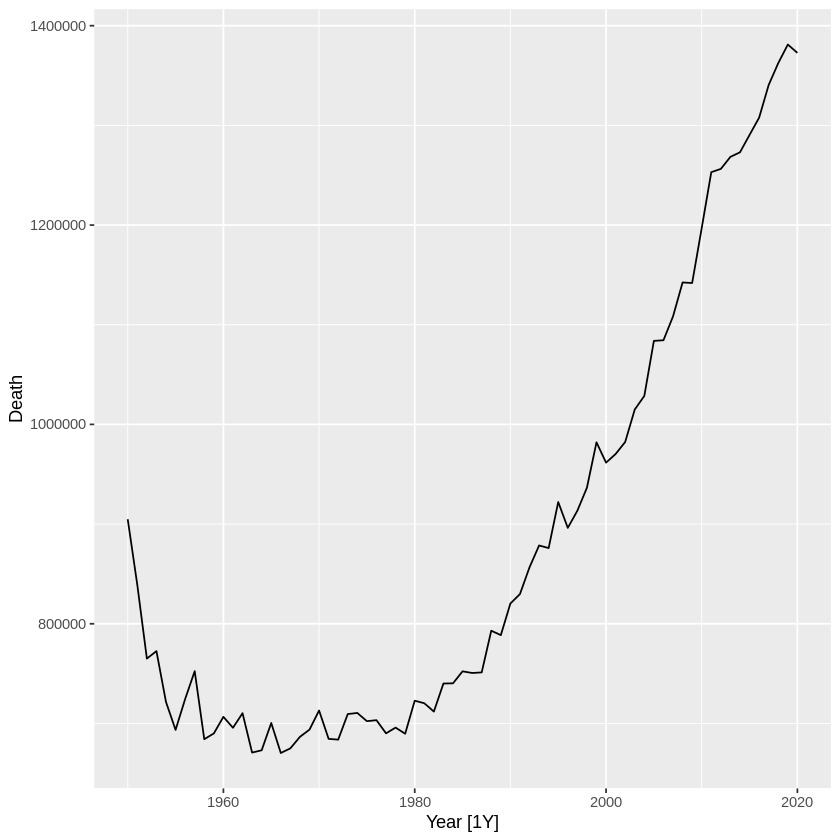

In [13]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡数のグラフ
pop_tsibble |>
  autoplot( Birth )
pop_tsibble |>
  autoplot( Death )

次に、自己相関を確認してみます。

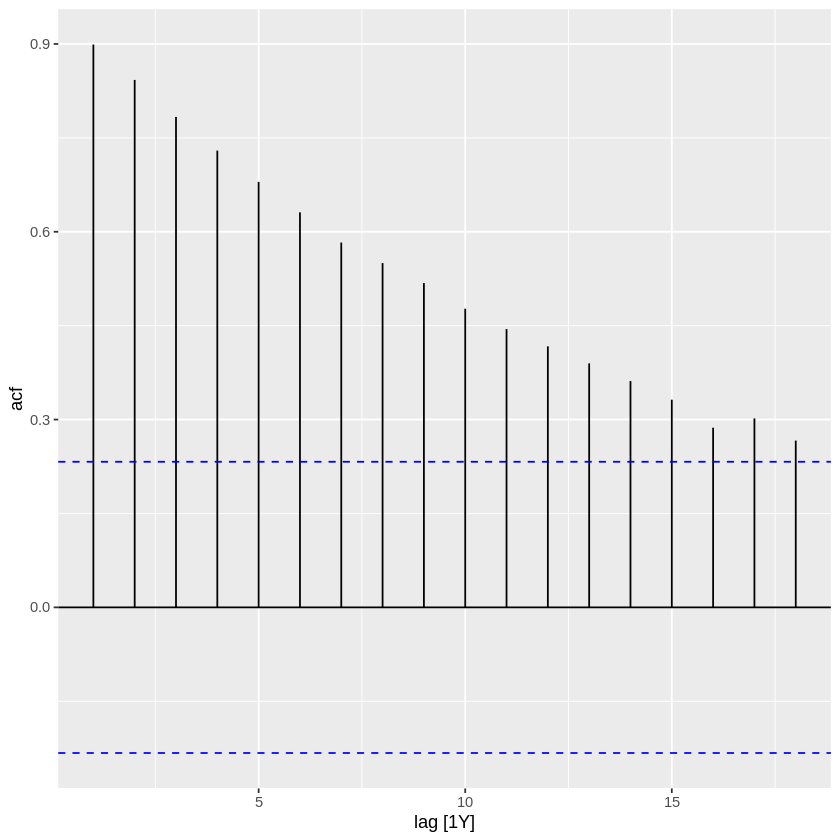

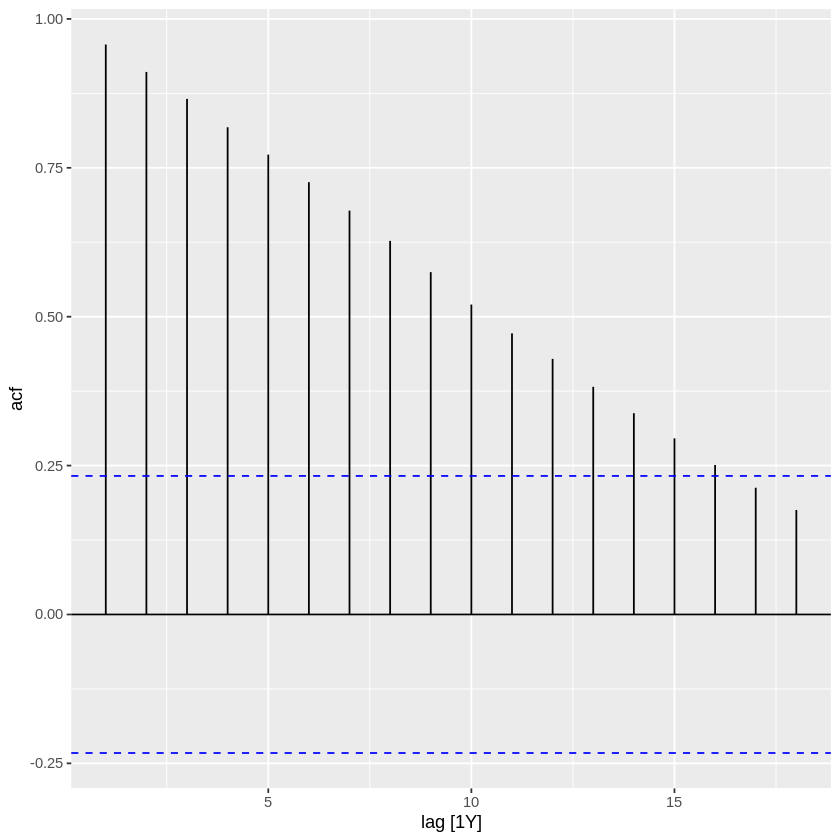

In [14]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble |>
  ACF( Death ) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

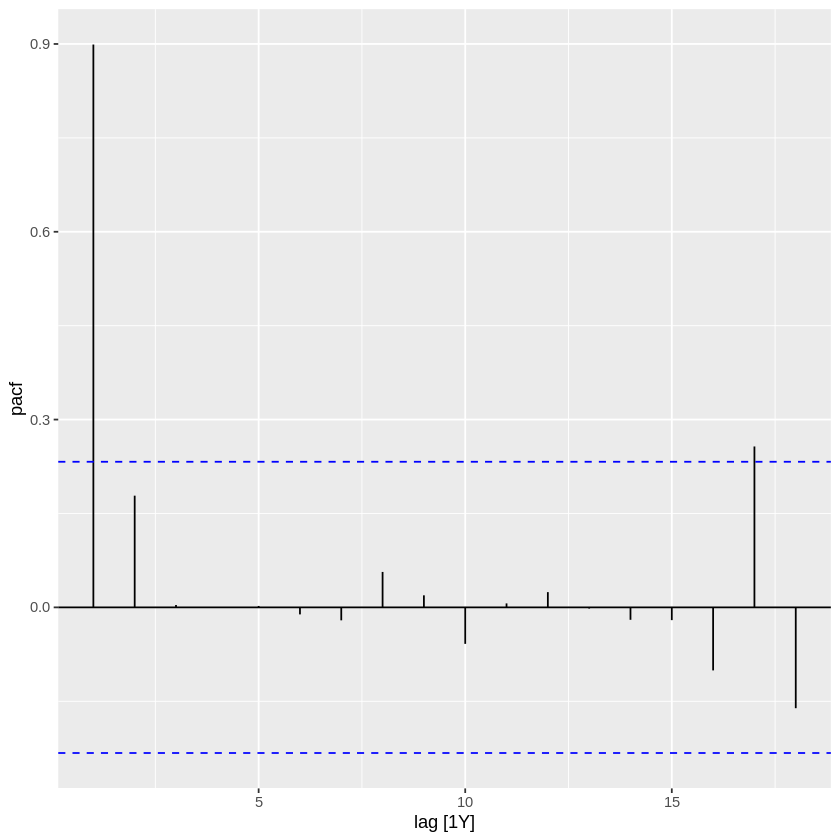

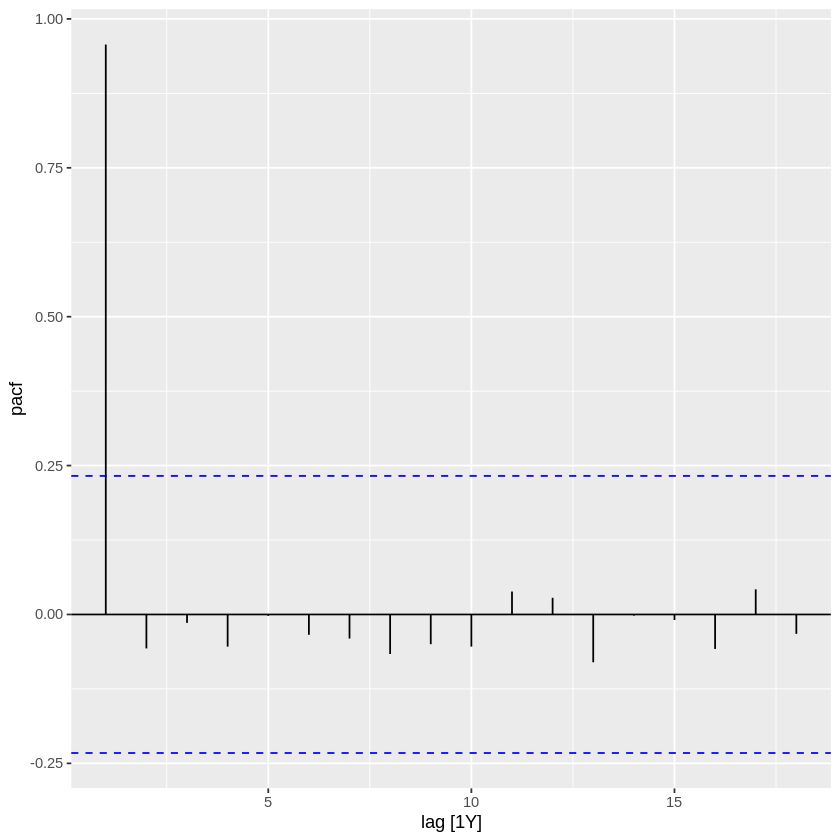

In [15]:
# 偏自己相関のグラフ
pop_tsibble |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble |>
  PACF( Death ) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [ ]:
# 学習データと予測データ
6 -> prow_test2
pop_tsibble |> nrow() - prow_test2 -> prow_train2
pop_tsibble |> tail( n = prow_test2 ) -> pop_test2
pop_tsibble |> head( n = prow_train2 ) -> pop_train2

# 手順４　ＶＡＲモデルによる予測

まず、学習データを使ってＶＡＲモデルを推定します。

In [17]:
# ＶＡＲモデルの推定
pop_train2 |>
  model( var = VAR( Birth,
                    ic = "aic",
                    stepwise = FALSE )) -> pop_var_B
pop_train2 |>
  model( var = VAR( Death,
                    ic = "aic",
                    stepwise = FALSE )) -> pop_var_D
  pop_var_B
  pop_var_D

var
<model>
<VAR(5)>


var
<model>
<VAR(5) w/ mean>


それぞれ、ＶＡＲ（５）が推定されたので、予測してみます。

In [18]:
# ＶＡＲによる予測
pop_var_B |>
  forecast( h = "6 years") -> pop_var_fB
pop_var_D |>
  forecast( h = "6 years") -> pop_var_fD
pop_var_fB
pop_var_fD

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
var,2015,"N(1e+06, 8.7e+09)",1001185.9
var,2016,"N(989332, 1.1e+10)",989331.9
var,2017,"N(979222, 1.6e+10)",979222.0
var,2018,"N(970318, 2.2e+10)",970317.7
var,2019,"N(963375, 2.8e+10)",963374.9
var,2020,"N(953997, 3.4e+10)",953996.6


.model,Year,Death,.mean
<chr>,<dbl>,<dist>,<dbl>
var,2015,"N(1315510, 4.8e+08)",1315510
var,2016,"N(1344061, 7.2e+08)",1344061
var,2017,"N(1370213, 9e+08)",1370213
var,2018,"N(1404659, 1.2e+09)",1404659
var,2019,"N(1442147, 1.7e+09)",1442147
var,2020,"N(1477057, 2e+09)",1477057


# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [19]:
# 出生数、死亡数の合算
# ライブラリの読み込み
library( dplyr )

pop_test2 |> rename( "forecast_BD" = Total ) -> pop_var_f2
pop_var_fB |>
  as.data.frame() |>
  select( .mean ) -> pop_var_f2[,3]
pop_var_fD |>
  as.data.frame() |>
  select( .mean ) -> pop_var_f2[,4]

pop_var_f2 |>
  mutate( forecast_BD = lag( forecast_BD + Birth - Death )) -> pop_var_f2

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126780676,126838000,126864000,126912000,126938000
2017,126706000,126578271,126532000,126605000,126704000,126777000
2018,126443000,126315009,126177000,126315000,126441000,126580000
2019,126167000,126008659,125773000,125998000,126125000,126351000
2020,126146000,125688228,125325000,125658000,125761000,126094000


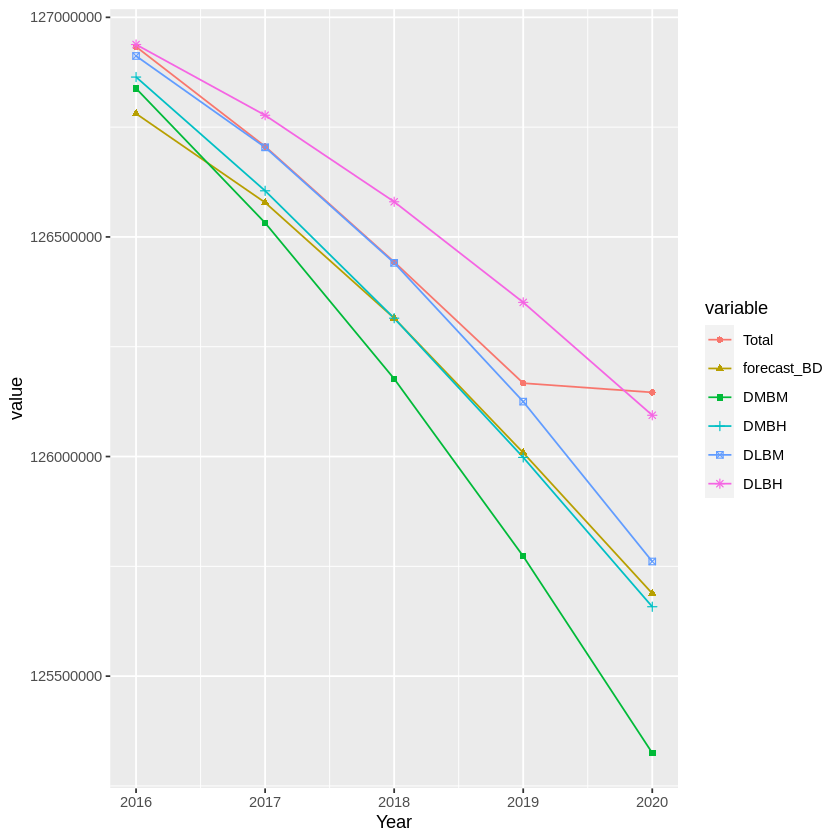

In [21]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/forecast_ipss.csv" )) -> ipssURL

# ネット上のファイル読み込み
ipssURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> ipss_test

pop_var_f2[ 2:6, 1:2 ] |>
  inner_join( pop_test2, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) -> join_test2
join_test2

# ライブラリの読み込み
library( reshape2 )

join_test2 |> 
  melt(id="Year",measure=c( "Total",
                            "forecast_BD",
                            "DMBM",
                            "DMBH",
                            "DLBM",
                            "DLBH")) -> join_plot2

#描画
ggplot( join_plot2,
        aes(x = Year,
            y = value,
            shape = variable,
            colour = variable,
            group = variable )) +
  geom_line() +
  geom_point()

今度は少し低めに出てしまいました。  
ＡＲＩＭＡモデルよりは、僅かに実測値に近いようです。

# 次のステップ



*   同じ事をPythonでやってみる。　->　こちら
*   同じ事をＧＡＲＣＨモデルでやってみる。　->　こちら
*   死亡率を使って推計する　->　こちら

